In [56]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
from io import StringIO
import csv
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit



In [112]:
df = pd.read_csv("formattedVotes.csv", encoding="utf-8")
df['voteSpace'] = df['voteChoice']
df['voteChoice'] = df['voteCreated']
#print(df.head())
print(df.tail())

/home/jacob/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


         spaceIndex              spaceId spaceSymbol  \
2066999        5016  undeadpastelnft.eth         UPC   
2067000        5016  undeadpastelnft.eth         UPC   
2067001        5016  undeadpastelnft.eth         UPC   
2067002        5018       skylinedao.eth         ETH   
2067003        5018       skylinedao.eth         ETH   

                                       spaceAddress  \
2066999  0x0811F26C17284B6E331Beaa2328471107576e601   
2067000  0x0811F26C17284B6E331Beaa2328471107576e601   
2067001  0x0811F26C17284B6E331Beaa2328471107576e601   
2067002  0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b   
2067003  0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b   

                                                proposalId  \
2066999  0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...   
2067000  0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...   
2067001  0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...   
2067002  0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...   
2067003  0xa591d4b2b14

#### change the voteChoice Collumn to something I can easily work with

In [2]:
#Here I am figuring out how many options I have on average. 
choices = df['proposalChoices']
counter = 0
options = 0
for choice in choices:
    if isinstance(choice, str): 
        counter += 1
        #print(choice)
        options += choice.count(',')

print(options/counter)




2.3194242188792655


convert all the ints and strings to one list. 

In [116]:
def processVoteChoice(voteChoice):
    vote = []
    if (isinstance(voteChoice, str)):
        if (voteChoice[0] == '['):
            #print(voteChoice + " [ string]")
            voteList = json.loads(voteChoice)
            for i in voteList:
                vote.append(int(i))
                vote.append(1)
            #print(vote)
        elif(voteChoice[0] == '{'):
            voteChoice = voteChoice.replace("\'", "\"")
            #print(voteChoice + "{ string")
            voteDict = json.loads(voteChoice)
            if(voteDict):
                for key, value in voteDict.items():
                    vote.append(int(key))
                    vote.append(int(value))
            #print(vote)
        else:
            try:
                a = int(voteChoice)
                vote.append(a)
                vote.append(1)
                #print(vote)
                #print("string")
            except ValueError:
                print(voteChoice + " string except")
    elif (isinstance( voteChoice, int)):
        vote.append(voteChoice)
        vote.append(1)
        #print(vote)
        #print("int")
    else:
        print("error")
    return vote
df['processedVotes'] = df['voteChoice'].apply(processVoteChoice)


In [117]:
print(df['processedVotes'].head())

0    [1, 1]
1    [1, 1]
2    [2, 1]
3    [1, 1]
4    [2, 1]
Name: processedVotes, dtype: object


Taking and creating a cumulative summarry for each proposal. 

In [112]:
def makeBarChart(proposalGroup):
    d = dict()
    for  index, choice in enumerate(proposalGroup.iloc[0]['proposalChoices']):
        d[index] = 0
    #for item in proposalGroup['spaceIndex']:
        #print(item)
    for vote in proposalGroup['processedVotes']:
        key = -1
        val = -1
        #print(vote['processedVotes'])
        for count, item in enumerate(vote['processedVotes']):
            if(count % 2 == 0):
                key = item
            else:
                val = item
            if(key != -1) & (val != -1):
                d[key] = d[key] + val
                key, val = -1
    return d
def addVotesToDictionary(dictionary, items):
    key = -1
    val = -1
    for count, item in enumerate(items): 
        if(count % 2 == 0):
            key = int(item)
        else:
            val = int(item)
        if((key != -1) & (val != -1)):
            if(dictionary.get(key) == None):
                dictionary[key] = 0
            dictionary[key] = dictionary[key] + val
            key = -1
            val = -1
    return dictionary


def makeBarCharts(df):
    proposalDicts = dict()
    d = dict()
    for i in range(0, len(df)):
        #for each freaking row
        #if it's not the first row and we haven't change proposals. 
        currentRow = df.iloc[i]
        prevRow = df.iloc[i-1]
        if( i == 0):
            d = addVotesToDictionary(d, currentRow['processedVotes'])
            #we're on a new proposal group here
        elif(currentRow['proposalId'] != prevRow['proposalId']):
            proposalDf = pd.DataFrame.from_dict(proposalSummaries)
            if(i < 200):
                print(proposalDf)
            proposalDicts[prevRow['proposalId']] = d
            try:
                df.loc[df['proposalId'] == prevRow['proposalId']['proposalSanpshot']] = d
            except:
                continue
            d = dict()
            d = addVotesToDictionary(d, currentRow['processedVotes'])
            #another row in the same proposal
        else:
            d = addVotesToDictionary(d, currentRow['processedVotes'])
    return proposalDicts

#proposalGroups = df.groupby(['proposalId'])
#proposalGroups.apply(print)
proposalSummaries = makeBarCharts(df)

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

       QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N  \
1   1010010100101267877834716101612606413660165218...   
2   1000010110400999994221880296595791682318348395...   
3   1000000000000000037340933747145988971939327575...   
7                                             4543229   
6                                           102760185   
..                                                ...   
65                                                 28   
76                                                 73   
82                                                 45   
83                                                 40   
81                                                 30   

   0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b  \
1   1010010100101267877834716101612606413660165218...                   
2   1000010110400999994221880296595791682318348395...                   
3   1000000000000000037340933747145988971939327575...                   
7                      

KeyboardInterrupt: 

saving the above so I don't have to do this computation again. 

In [36]:
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(proposalSummaries, f)

Saving the dataframe so I don't have to do this again. 


In [38]:
df.to_csv('processedVotes.csv')

In [7]:
table = pd.pivot_table(
    df, 
    values=["voteId"],
    index=["spaceIndex"],
    columns=["proposalId"], 
    aggfunc='count',
    margins =True
)
stackedTable = table.stack("proposalId")
#stackedTable.to_csv("voteCounts.csv")
print(stackedTable)




                                                               voteId
spaceIndex proposalId                                                
0          All                                                   52.0
           QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N        52.0
1          0x09374294f4d04e4e7bdc6e40f07b41cc65084a5a14a36...     6.0
           0x0eb9b28e6d22dc399ad95cc252f0b27d3a6305b3370f1...     2.0
           0x1062992c608c9880cf24484582900bcd4d03f7b7b1193...     1.0
...                                                               ...
All        QmfZESnQqDRupDdYxdhJ55EHmRctrnH5GVFc7UUsxEciQx        67.0
           QmfZKe7pQHReYZTZwVf3YU257Z6X8r3dqGMfeVdnZ9D1kS        22.0
           QmfZbxX4grLQ3sF5TgQk73UcF68RtwaG1MRM36APBfLEji         1.0
           QmfZcGFvDdJCLnh14k6g9kSCcfYqpPp9vFKvdxT9GxANUq         8.0
           QmfZwNugA3taZ95NeuoRDoyLuFcrcQFdLtML4CT3tzzzBh        81.0

[49706 rows x 1 columns]


In [8]:
spacesVoteCounts = df.groupby('spaceIndex').count()
print(spacesCounts.head())
spacesCounts.to_csv("spacesCounts.csv")



NameError: name 'spacesCounts' is not defined

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.hist(spacesCounts['spaceId'], bins = 'auto')
plt.title("Histogram with 'auto' bins")
plt.show()
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()



In [ ]:
proposalCounts = df.groupby('proposalId').count()
proposalCounts.to_csv("proposalCounts.csv")

In [ ]:
noVotes = df.drop_duplicates(subset = ['proposalId'])
print(noVotes.head())

In [ ]:
spacesProposalCounts = noVotes.groupby('spaceIndex').count()
print(spacesProposalCounts.head())

spacesProposalCounts.to_csv("spacesProposalCounts.csv")

## Section 2 Analyzing Vote Behaviour

In [4]:
#This is just to load the stuff I've already done.
df = pd.read_csv("processedVotes.csv", encoding="utf-8")
with open('saved_dictionary.pkl', 'rb') as f:
    proposalSummaries = pickle.load(f)

/home/jacob/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,7,11,16,17,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# making some iterators and helper functions.
def voteChoices(stream):
    for n, y in enumerate(stream):
        if n % 2 == 0:
            yield y
def voteWeights(stream):
    for n, y in enumerate(stream):
        if n % 2 != 0:
            yield y
def votes(stream):
    for n, y in enumerate(stream):
        if n % 2 != 0:
            weight = y
        else:
            choice = y
    yield(choice, weight)
def votesFromLists(stream1, stream2):
    for choice, vote in zip(stream1, stream2):
        yield (choice, vote)

def listify(string ):
    try:
        return list(string.replace("[", "").replace("]", "").replace(",", "").split(" "))
    except:
        return string

def makeBarCharts(df):
    proposalDicts = dict()
    d = dict()
    for i in range(0, len(df)):
        #for each freaking row
        #if it's not the first row and we haven't change proposals. 
        currentRow = df.iloc[i]
        prevRow = df.iloc[i-1]
        if( i == 0):
            d = addVotesToDictionary(d, currentRow['processedVotes'])
            #we're on a new proposal group here
        elif(currentRow['proposalId'] != prevRow['proposalId']):
            proposalDicts[prevRow['proposalId']] = d
            try:
                df.loc[df['proposalId'] == prevRow['proposalId']['proposalSanpshot']] = list(d.items())
            except:
                continue
            d = dict()
            d = addVotesToDictionary(d, currentRow['processedVotes'])
            #another row in the same proposal
        else:
            d = addVotesToDictionary(d, currentRow['processedVotes'])
    return proposalDicts
def makeBarChart(proposalGroup):
    d = dict()
    for  index, choice in enumerate(proposalGroup.iloc[0]['proposalChoices']):
        d[index] = 0
    #for item in proposalGroup['spaceIndex']:
        #print(item)
    for vote in proposalGroup['processedVotes']:
        key = -1
        val = -1
        #print(vote['processedVotes'])
        for count, item in enumerate(vote['processedVotes']):
            try :
                item = int(item)
            except:
                continue
                
            if(count % 2 == 0):
                key = item
            else:
                val = item
            if(key != -1) & (val != -1):
                d[key] = d[key] + val
                key, val = -1
    return d
def addVotesToDictionary(dictionary, items):
    key = -1
    val = -1
    
    for count, item in enumerate(items): 
        try :
            item = int(item)
        except:
            continue            
        if(count % 2 == 0):
            try:
                key = item
            except: 
                print("exception occured")
                key = 1
        else:
            val = item
        if((key != -1) & (val != -1)):
            if(dictionary.get(key) == None):
                dictionary[key] = 0
            dictionary[key] = dictionary[key] + val
            key = -1
            val = -1
    return dictionary


In [6]:
df.head()
df.astype({'voteCounts': 'float'}).dtypes
df.astype({'totalPropVotes_y': 'float'}).dtypes
df.astype({'voterWeight': 'float'}).dtypes
df.astype({'processedVotes': 'object'}).dtypes
makeBarCharts(df)
df['processedVotes'] = df['processedVotes'].apply(listify)


I want to get the total votes for each proposal. 

In [120]:
# helper function
def getVotesNum(votesList):
    count = 0
    for ind, vote in enumerate(votesList):
        if ind %2 != 0:
            count += vote
    return count
df['voteCounts'] = df['processedVotes'].apply(getVotesNum)

TypeError: unsupported operand type(s) for +=: 'int' and 'str'

In [7]:
#summing the votes for each proposal and adding it to the data frame. 
df = df.merge(df.groupby('proposalId')['voteCounts'].sum().rename('totalPropVotes'), on='proposalId', how='left')


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
#dropped unnecessary columns. 
df = df.drop(columns = ['totalPropVotes_x', 'proposalStart.1'])


I'm now getting the weight of each voter. 

In [118]:
#getting each voters weight in the decision. 
try:
    df['voterWeight'] = df['voteCounts'].divide(df['totalPropVotes_y'].replace(0, 1)).replace(np.inf, 0)
except ZeroDivisionError:
    print("0")
#df['totalPropVotes_y']
df.tail()

TypeError: unsupported operand type(s) for /: 'str' and 'str'

I want to merge my dictionary into the df. 

In [153]:
#just testing weights and votes. 
df['processedVotes'] = df['processedVotes'].apply(listify)
a = df['proposalId'].unique()
i = 0
while i < 5:
    print(a[i])
    i += 1
dfTemp = df[df['proposalId'] == a[100]]
print(dfTemp.iloc[1])
one = dfTemp.iloc[1]

print("choice")
for choice in voteChoices(one['processedVotes']):
    print(choice)
    
print("weight")
for weight in voteWeights(one['processedVotes']):
    print(weight)
print("votes")

for vote in votesFromLists(voteChoices(one['processedVotes']), voteWeights(one['processedVotes'])):
    print(vote)


QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N
0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b
0x0eb9b28e6d22dc399ad95cc252f0b27d3a6305b3370f16d40d4d0457ca320a98
0x8a9252930f5de941573067b5d5ca61e24f28ec80769f47971fc1a50ed3759ec6
0xdb3db598619da2d17e528e145153fcd03f28aa7ed39e3bb8a9795b7bd2a96431
Unnamed: 0                                                  1749.0
spaceIndex                                                       1
spaceId                                                 fabien.eth
spaceSymbol                                                      $
spaceAddress            0xeF8305E140ac520225DAf050e2f71d5fBcC543e7
proposalId          Qmc7kL4hP1YjBnkfFEadQjrSQmzj4kCFYtFY5ur8bXNWiW
proposalTitle                               This is a test for RCV
proposalBody                                                   Hi!
proposalChoices         ['Alice', 'Bob', 'Carol', 'David', 'Eric']
proposalStart                                         1622523600.0
proposalEnd    

The votes are stored as a dataframe. Wnen oyu load the dataframe you need to explicitly tpye collumns where you care about the type.
The processed vote collumn is stored as a string object. So you have to run it through makeBarCharts and listify on processedVotes to make it back into a list. Then the get Choices and get weights should work. 


In [10]:
class Vote:
    choiceName = 0
    choiceWeight = 0
    def __init__(self, name, weight):
        self.choiceName = name
        self.choiceWeight = int(weight)
    def add(self, weight):
        self.choiceWeight += int(weight)
class VoteList:
    propName = ''
    votes = list()
    def addVote(self, vote):
        option = vote.choiceName
        present = False
        for v in self.votes:
            if v.choiceName == option:
                v.add(vote.choiceWeight)
                present = True
        if present == False:
            self.votes.append(vote)
        #print(self.votes)
    def addVotestoVoteList(self, df):
        lists = df['processedVotes']
        #print("processedVotes")
        for thing in lists:
            #print(thing)
            for vote in votesFromLists(voteChoices(thing), voteWeights(thing)):
                #print(self.votes)
                self.addVote(Vote(vote[0], vote[1]))
    def getWinningVote(self):
        for vote in self.votes:
            if highest == None:
                vote = highest 
            if vote.choiceWeight > highest.choiceWeight:
                highest = vote
        return highest
    def __init__(self, df, propName, l):
        self.votes = l
        self.addVotestoVoteList(df)
        self.propName = propName

def getWinningVote(votes):
    highest = None
    for vote in votes:
        if highest == None:
            highest = vote 
        if vote.choiceWeight > highest.choiceWeight:
            highest = vote
    return highest
    
def getTotalWeight(votes):
    weight = 0
    for vote in votes:
        weight = weight + vote.choiceWeight
    return weight

def findPropSummary(propSummaries, name):
    for prop in propSummaries:
        if prop.propName == name:
            return prop

def printVotes(prop):
    for vote in prop.votes:
        print("choice:" + str(vote.choiceName) + " weight:" + str(vote.choiceWeight))
        
def getVoteWeight(vote):
    vote = listify(vote)
    weight = 0
    for v in voteWeights(vote):
        weight += int(v)
def wonVote(vote, winningChoice):
    try:
        vote = listify(vote)
        for v in voteChoices(vote):
            if v == str(winningChoice):
                return True
        #print(winningChoice)
        #print(list(voteChoices(vote)))
        return False
    except:
        print("exception occured")
        return False


In [11]:
proposalIds = df['proposalId'].unique()
proposalSummaries = []
for prop in proposalIds:
    try:
    #print(prop)
        l = list()
        tempDf = df[df['proposalId'] == prop]
        v = VoteList(tempDf, prop, l)
        proposalSummaries.append(v)
    except:
        continue

In [311]:
len(proposalSummaries)/len(proposalIds)
# it seems I missed one. No big deal. 

0.9995294318959617

In [347]:
for prop in proposalSummaries:
    try:
        print(prop.propName)
        vote = getWinningVote(prop.votes)
        totalWeight = getTotalWeight(prop.votes)
        print("choice:" + str(vote.choiceName) + " weight:" + str(vote.choiceWeight) + " percentage:" + str(vote.choiceWeight/totalWeight) + "\n")
    except:
        continue

QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N
choice:1 weight:46 percentage:0.8846153846153846

0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b
choice:1 weight:1 percentage:0.3333333333333333

0x0eb9b28e6d22dc399ad95cc252f0b27d3a6305b3370f16d40d4d0457ca320a98
choice:2 weight:2 percentage:1.0

0x8a9252930f5de941573067b5d5ca61e24f28ec80769f47971fc1a50ed3759ec6
choice:3 weight:1 percentage:1.0

0xdb3db598619da2d17e528e145153fcd03f28aa7ed39e3bb8a9795b7bd2a96431
choice:1 weight:1 percentage:0.3333333333333333

0x8b3aa67986844d9e666c6a8b6985db335d0201261d257c9b1078eae437464821
choice:3 weight:1 percentage:1.0

0x1062992c608c9880cf24484582900bcd4d03f7b7b119387285988ac52f4ea463
choice:1 weight:1 percentage:1.0

0x4e7bce6cd52cb262953bbf4a42c262ea7f4ba7fc04de80f6ea6a7e89a51d9a36
changing highest to 1
choice:1 weight:2 percentage:0.6666666666666666

0x1f4ac19e3135dd3f4eb4cad0ff4c4e4fbacf760cd6252e86b38ea1a70da9acea
choice:1 weight:2 percentage:0.6666666666666666

0x2b0b334737a

choice:1 weight:69 percentage:0.9857142857142858

QmRFrmLp4hQwVkz1k7Lf8fWkAQ9v2a4RBuohvgaYNruvAC
choice:1 weight:56 percentage:1.0

QmXdNMddkVTwVmm7X3Ew1SmsyuHLmGADW4R5k3dspiHitk
changing highest to 6
choice:6 weight:69 percentage:0.5433070866141733

QmaSLgS5i4w3otfqgaR36c1aZQdHAaFBKgwzL4WX6YP93d
choice:6 weight:11 percentage:0.6111111111111112

QmQNRbxiLQtWeQth8fw1SZyuWQaEjpDpxnTY5pqByWtz6h
choice:1 weight:33 percentage:0.9428571428571428

QmfLnh9W7G7JFfx6Yuc17kT2YzU4UpSzNZnJA66SqMrugi
choice:1 weight:45 percentage:0.9574468085106383

QmSdGX19MQie62jtndySU9kgbNTUtjhUzm3NCcAwpD2vjw
changing highest to 1
choice:1 weight:6 percentage:0.6

QmWKdJebVQT1ip9dLJD28vhUAvPkdaXDX6sQZAYrrxH8wA
choice:1 weight:12 percentage:0.9230769230769231

QmQJYchB8rsVBBAdDzM4Mfbz19Wm7A22eikdXdGLfu6F5T
changing highest to 2
choice:2 weight:12 percentage:0.42857142857142855

QmbDq3rEkbfHprAjJ4iXRME74NpfrQkKUMfkv2idnid1w6
choice:2 weight:1 percentage:1.0

QmX6Y9XbBNJEdcKyvfxuhE94Ph88Cp4Zag2UTxGYCrmQDD
changing h

QmWp1d2ky1hNZPhPorhAhPLrXPqJ3LthKboKuyuscHf97d
choice:1 weight:11 percentage:1.0

QmV9o1AiZSVZ5fdKJXYmGTcnYQodP8h1gWt9EEMaNFXsDs
changing highest to 1
choice:1 weight:24 percentage:0.9230769230769231

QmeipWg3SsSaz3NHqavKKiJ8SfPcAZTfozDSY1wZw9kfLo
choice:1 weight:26 percentage:1.0

QmTWjGB5nUSa4k3jGn3Lb6Ka6adD1tLabW56gDSpg8BR2q
choice:1 weight:17 percentage:1.0

QmWyzFnBDhEzENVQqhwZzyUSZF3qTg6p3gcMC6VKsvvcCr
choice:3 weight:17 percentage:0.85

QmaKu7MQd68AaY18Ab3iBSajfqzWeqQyoCTyfwP5syD1nh
changing highest to 11
choice:11 weight:5 percentage:0.23809523809523808

QmPDw5uewBgmVkw55fnm82TdqRKMhqf6EsP4RMu5sHFLGY
changing highest to 8
changing highest to 16
choice:16 weight:9 percentage:0.3103448275862069

QmaTVUZm2iXGZgKxGXqP6QXX4wifj1fVFDztLDHx3qKJ7F
choice:1 weight:5 percentage:0.8333333333333334

QmYXaD6z743wbXbobPBTJsjJtUDEbRchNsF6632eVj6YnN
choice:1 weight:1 percentage:1.0

QmYP9Cjm6Hyhoz1FtDDcgPYSrTEAyrHRDKqpt4SWXotnEB
choice:1 weight:4 percentage:1.0

Qmb5JxuaxM57vx2DEFTxvCbAP6m9Bnz


QmYF62qGaqyHAXt88Hmxise6CFaSWxnTmi5VedZ3VX8Zy2
choice:1 weight:259 percentage:0.7551020408163265

QmPM1D8fVG8eNoQnhnNKUZb3imPSwnv3bDyDqeh91BaFbw
choice:5 weight:19 percentage:0.2

QmZf78TcA8NaHC8asRSnKKfx9Ve4VS7szu5CGAHGzBJ7eH
choice:2 weight:100 percentage:0.7092198581560284

QmQvoNCNhz5dARMgR82vFPeHAMPqMahHgsHjPYggFuAkGZ
choice:2 weight:86 percentage:0.8958333333333334

QmNqYFVyeadbuPfLrxLi2PKjoXwSWTCar4bjzFyk5Kt7v8
changing highest to 1
choice:1 weight:7 percentage:0.7

QmPyGY7VnvPjaJcMNiW1vhVCZAJFhYrb9vsYQvwJZz9zgW
choice:1 weight:32 percentage:0.7272727272727273

QmQtXQQnVoNA2oyLrZjNmGpMXUpR84VKBwtwkPcgzQZdgQ
choice:1 weight:15 percentage:0.9375

QmTCKRJadH8Jm2oZKNhPUegAtZBEJmdV2aSeGVC272txhn
choice:1 weight:2 percentage:1.0

QmZTs1QURHp9QCMR5q6HKcDQQC4T4ckNW1CBHKzgAJyiwp
choice:1 weight:2 percentage:1.0

QmXUmbGHQtPqKuMf3DQgQhNQCWnVH7rMdQm7qXCEPqmiuJ
choice:1 weight:3 percentage:1.0

QmViCfjg4y223A9RCFMgaeAqH8T7mdUEtZcuHFMvLQ45PH
choice:1 weight:1 percentage:1.0

QmViWw837MpTGUy

QmVeuq5dNDmGhBRfMgcYzfPoXhLDgdGy67PegoDqakyFhz
changing highest to 1
choice:1 weight:13 percentage:0.5416666666666666

QmbKM8vgDKkU1GrtZCmnWKTCdRS59ES5Cab1vWxb3rGdAE
changing highest to 1
choice:1 weight:17 percentage:0.9444444444444444

QmfDT3W5HgGfyKDAaGdP4p3m5idpjce28vAbQVYrcazNmz
choice:3 weight:1 percentage:0.5

QmaVWSPHt4JyrUQ4fDjtoEKndaCe1gxyP213biRf5RSMCq
choice:1 weight:14 percentage:0.875

QmXqMwPxoQTtpHpTSkY8GsaJM9TVuno3ULPZsJkczWucSN
choice:2 weight:13 percentage:0.38235294117647056

QmZKGCJJxnDekZhRgS7BBQiJuEYctTi5azZk5KfibWNpHM
choice:3 weight:19 percentage:0.4523809523809524

Qmbq4yQq7jmU3GYjqu8AXQcQeXySz3ypWXQHDUDqNwox3X
choice:1 weight:34 percentage:1.0

QmR9o5RsnTmz6ZBM2spgz6NjLLnTNbDokv3LiC3ZqM2P6T
choice:1 weight:26 percentage:0.8387096774193549

QmUWC3CpybBwjCxKDKLRq31SFwunXgebatwoZrQsFmHe4E
choice:1 weight:40 percentage:0.975609756097561

QmRpZuPjMgQP4EPxenAAqgnum88oT8MUDjT64jmCTeyhmA
choice:1 weight:29 percentage:0.8055555555555556

Qma9ni9yL7XQufmcprrG6NVA7HLQcm

changing highest to 1
choice:1 weight:9 percentage:0.6428571428571429

QmcrBnownQX45sSgaaSH6F9yFMHJLMvVbSA3DDRYmK4VvK
choice:1 weight:9 percentage:1.0

QmVvbn9DmVubEnsAm4hdiYqBFa9HR1NqTGVf5zSg1Uf6i1
choice:1 weight:18 percentage:0.9

QmSxQ8GFKP62WAQYdTDDNaenwXF4ae1oyBbPp9xDL3fmSN
choice:1 weight:1 percentage:1.0

Qmea8LcjXxqedd7P24buTw55ApJd7bxjipgjGhxpdjUUxX
choice:1 weight:14 percentage:0.875

QmRko5KaFYTkprjZgryKtGL9G1U9Chuyx3mTXVtLJ6WVzA
choice:1 weight:8 percentage:0.8888888888888888

QmWJzg88bfAzvX5k5dmr5443mnzX16vgkuGr8crnwNhfWv
changing highest to 1
choice:1 weight:6 percentage:0.6666666666666666

QmYfs34d6UaCxqXi9trV8ufiqNr6dxPd95L5rLZdXYK4ZG
choice:1 weight:10 percentage:1.0

QmSBf1wNFRiULzUNvMSkcEZAnxSfdZvSqiNAWuUNvLiBsp
choice:1 weight:9 percentage:0.8181818181818182

QmNVZx6re5DKVXGrSY3h14bgmAksmCrzTi4976WsYgn5p6
choice:1 weight:17 percentage:1.0

QmXdtxvGYscDUsrEVCNpRbbLRLYcfhDvpQhNmA7rKQdrkS
choice:1 weight:8 percentage:1.0

QmZP4vmWEpEg9aJczPR8CCBpvyXh8bBqTTKeuJm2c6fEV4

choice:1 weight:1 percentage:1.0

Qmc8DLyHyzStWdWFRYZ5x2p73pS36wza3v8kGEZbpZPPyq
choice:1 weight:1 percentage:1.0

QmSDB8ju2TLHuLHoChW4efHeauGC2V13ZrXFyGvxNUutrM
choice:1 weight:1 percentage:1.0

QmW1paotKoY8fN7mWUfTP4MuC4Bst6GDZMdFG3QtxuB1sh
choice:1 weight:1 percentage:1.0

QmcwEa3MGKAZboR14JPgYdJzvmALYQCe9zLx2YNSTWZkTo
choice:1 weight:1 percentage:1.0

Qma6T5vkp4muzMGaDc5AqbosRcUAKjPgzDF7CYFQZwfXMk
choice:1 weight:1 percentage:1.0

QmWCCwuuHQUakArsRqqhDrqsrjGFYf1BiuazvCgYJKjNgP
choice:1 weight:1 percentage:1.0

QmYdDZnjNGpmHwvEYx33dQdP78TxMkt9L4DgXADMXfUyF1
choice:1 weight:1 percentage:1.0

QmPanFfyoLiiPxeKavd8tj4rJkB6Uzm7rMDn1xPCjA3VWT
choice:1 weight:1 percentage:1.0

QmVV5JqZEiHkNNpkysUURzGjczxKTXd96SGpTB8kiP8aEQ
choice:1 weight:1 percentage:1.0

QmTissp34fKfK8pbN2EigHvJfDqUYsECQ9HTyezniZbWn6
choice:1 weight:1 percentage:1.0

Qmba3hWhCjHXtomQ77G8d5gb1xjbHiw7pxVA7JB7HHRL4r
choice:2 weight:1 percentage:1.0

Qmchmzn5i83msWs9zPF8rUsjdfGohTNNgyczbhZy4GZ89A
choice:1 weight:1 percentage

0x03c44532e72a5c4addb70dbba3813db12c0c797301c44ba25069db5e8d172b52
choice:1 weight:1 percentage:1.0

0x75637dbe002062a4844685d36b4702da53020d46b77847fc067219f800282ad2
choice:2 weight:1 percentage:1.0

0xc96c782a6d1d78ec97bf5372e68bd1dc139ad786366afc1a04d97c6a792805b4
choice:1 weight:1 percentage:1.0

0x3393855a3021bfdda9b2e51fd3e41209040e86d2eaa8702a54fe25469bb869f6
changing highest to 1
choice:1 weight:7 percentage:0.6363636363636364

0xe6fae71c28bd78cc64386abc6ed14468ff0d6ddbddeac08889dcde977c777d50
choice:2 weight:4 percentage:0.8

0x4bf3aaea93b84331a9903dbe7341b7afc712915700a31b351bb572a5cf81b001
changing highest to 2
choice:2 weight:4 percentage:0.6666666666666666

0xb7d525fff6e102064c248634a19b54dbad724f11106a29888ca55a2eed0bac1c
choice:2 weight:2 percentage:1.0

0xe0c31487c375ba14fa8ac7b5ff18a0319b065641b61d747d39074270662fb321
choice:1 weight:1 percentage:1.0

0xeb25e2d47152ea438e2c9f07f10f0f84d84ede103f787e9b471f0a7f0b20d1ef
choice:1 weight:1 percentage:1.0

0xe34cbc2349e537b

QmZpMPt9UFMdtyQpxi3ZQ5KJvzCJJYnXd99TTnm6Y6umT8
changing highest to 1
changing highest to 2
choice:2 weight:7 percentage:0.4375

QmTQeMN5qScZF6nx8Nj9Mq2AsqFp3HFp2KYoTFLL84dkCk
changing highest to 1
choice:1 weight:7 percentage:0.5384615384615384

QmeG8afyBo3GTjQa9oZgbbShJyc62wrCJ8VTadW7yKHNcK
choice:1 weight:9 percentage:0.5294117647058824

QmeGL6v6adXutDJHR25kK6P9CS62MpqUJHjYe9dwTvK2R1
choice:1 weight:12 percentage:0.8

QmRdz8zRgQV4RPWYcvUUSP8eRn77tVVBAAwzg1NEiJNrYK
choice:1 weight:13 percentage:0.6842105263157895

QmSNHfYH3bAJHdWoVAGy7E99xpTEi9uPY8dBy4U1G85hSj
changing highest to 3
choice:3 weight:1532392 percentage:0.9900529013017286

Qmf8s92f4T8MM7NZgxd4BAJ6ms4QMbF3z2CFUdg12jPVCT
choice:1 weight:11 percentage:0.9166666666666666

QmTziD6KrsY42xKwHVs1oUhQfjd4dzEkBXR4H16YP2tK4Z
choice:1 weight:4 percentage:0.8

QmRjyVGy1S6sKqEq4bWjd4ACgjBKYPFDuSYkDiSjmmJmdx
choice:1 weight:8 percentage:0.8888888888888888

Qmce4ywHcb8BstqTR4As61NAPUADryDtQiZNcXeCJF8MZA
changing highest to 1
choice:1 wei

choice:1 weight:30 percentage:0.6666666666666666

QmNcbw9wfZSSyLBGgTYGUrnHiNDKrvfsUEbMide3nCgUTF
changing highest to 1
choice:1 weight:16 percentage:0.4444444444444444

QmUwAtJZe3LzUto2Drqu2WKgaXdR5HMTVjofnBcBrAawGA
choice:1 weight:202 percentage:0.9853658536585366

QmXbbdMHTY918T399ywg38R82k6hsrUwTHg6eQAuxEBzw7
changing highest to 1
choice:1 weight:12 percentage:0.6

QmXVw89PjHgVqB4ELatafYDhJv6zFbc8JCcvtZshUjYdro
choice:2 weight:30 percentage:0.5084745762711864

QmRt694rABcrkM2F3f43HEW1cFbEdsAYXh7sSQKfCKfmzz
choice:1 weight:25 percentage:0.7575757575757576

QmTcjYjmxD6bSgWzrgtXTKDq9ebA9fn4tSffnxhUE2MHCQ
changing highest to 1
choice:1 weight:13 percentage:0.5909090909090909

QmfEL7SCah8uB2x16gdvbTBraCk7X1vYHPCuf2KDkkptWV
choice:1 weight:169 percentage:0.9657142857142857

QmVQQks8Ly2pi9tQUCfcLzg22DQN5BoQmi5sEMVYhPsGfX
changing highest to 1
choice:1 weight:13 percentage:0.7647058823529411

QmSFmNH2BBGaD75Q866zVZ869MpoUGQdCogGUGCAm9wEuA
changing highest to 1
choice:1 weight:11 percentage:


QmaDqCeW2LBiA9HGQmad3muSgBJTUWveeVwRgaNN7ZXuEj
choice:1 weight:1 percentage:1.0

QmX5s39x9nDyoNqFY9errPe8Z3Qc1dYgpc561BmRwJi8Bm
choice:1 weight:2 percentage:1.0

QmYYhn9mDSqkTXpPksEp39CAtzHgjWavDdwDeJ73jf8kjo
choice:1 weight:1 percentage:1.0

QmXioianvbHRGPQh1kPFiKc5yUGAPSGNxSeMjpdDxp82Z1
choice:1 weight:1 percentage:0.5

Qmc3wVLeN9uB1k49vrkxMGWNp9YpbakGim5ufAQ9ZeVvjG
choice:1 weight:1 percentage:1.0

QmfM3oE23VWTH8ouuDMwvrTPxXSgZ9LhY3gmrLgjHhcb4h
changing highest to 3
choice:3 weight:16 percentage:0.6956521739130435

QmNzACX85cHfL52GZP83rV4SqhP8f5tEcdLow2dfZJwan6
choice:3 weight:3 percentage:0.5

0xe0fd8ee2eadd7fac1f53792eede0c012c85c69ee9ea8c32b98665cfadcb4d2b5
choice:1 weight:3 percentage:1.0

0xc6f9d8ff2daa2f54c0f7f43265dac2f3d559301297eb9cc391a2c39dee08bb4d
choice:1 weight:1 percentage:1.0

0x210fb53ff59e5f0277bcc37c851272f462ec9f2453c20dd47f75db016f22d46c
choice:1 weight:4 percentage:1.0

QmYZiHDR837R2rYYjcKymBdWuuY8Lh6464TcFGAAXqENTf
choice:1 weight:1 percentage:1.0

Qmc8ixCxh4

QmYiiVVEspJAcNjZQd9aHgJGEuhu7zfmNsYxb6jbP9XXhg
choice:1 weight:1 percentage:1.0

Qme6m6jX53R9FM4NP93i8F3uovZv6FPQgT5fEP3iDXpa7D
choice:1 weight:2 percentage:1.0

QmQw4qceYJSPrcpRdEa6SDNC5G22oL4tWFqateSpSNR27u
choice:1 weight:3 percentage:1.0

QmNUXWEs2NhVbgwtn7euZBkD7c8LBFMfYmy3HDbUyQxPGg
choice:2 weight:2 percentage:0.6666666666666666

Qmc6CWegqr7NoRv3BzQLqUbMsse2onyVCgWVyA8LPsqXFw
choice:4 weight:1 percentage:0.3333333333333333

QmaCaenczc5RR9KmqsWyP8PRCAbsYoDmFv3RjyUeFEXPmX
choice:1 weight:3 percentage:1.0

QmY6Pfm3knXWioZn3W4sPFSiwuNDtkByyuJhMKfKbarKZA
choice:2 weight:21 percentage:0.6363636363636364

QmQS6QdVSrRd1LS1JZB4wNQTFxMV4GWKSc6L7uypHxmGhS
choice:1 weight:3 percentage:1.0

0x1842a252495853c423950d2fd9f6a3b186785ef0d42c67a6ddab40b729e0b263
choice:1 weight:31 percentage:0.96875

0xd1e851f75c6fae041859205c8179826f87d09119774b159f7db3a74552ff1b53
choice:1 weight:76 percentage:1.0

0x8fd4c1c4a20fd7a6d9ecd2796829dd2b8b933567454686581c8fc631923959e0
choice:4 weight:30 percentage:0

changing highest to 1
choice:1 weight:18 percentage:0.9473684210526315

QmadmSC2JbACWzW7M94AQSeYvfeU7f7Fuwm86cNeiGoqJc
choice:1 weight:1 percentage:1.0

QmZvduyAzFKyXrFUpgcebKWRJRamPP7XLvc3cPH3LHRqsi
choice:1 weight:2 percentage:1.0

QmPBm6rcDVXEQNF4BzBdNg55avq94d2eSDtVX2ijraXR3w
choice:1 weight:2 percentage:1.0

QmaKjR4P22Ne2zFTgoUisN9cVR3TRuQpDajHHgGR4xTT3b
choice:1 weight:2 percentage:1.0

QmPL5wAL877Gnri3T68Qa21cjhEai4sJEFXUmWAJvYkSCL
choice:1 weight:2 percentage:1.0

QmTpktk7rdc4TzNCyrfKPSiEYTEcsYyumXMyqKrQKbSCx5
choice:1 weight:1 percentage:1.0

Qmac5Rvb3M4PUPB4dbD5XdnaaEsav1iWVubT3Sk6REj3rv
choice:1 weight:2 percentage:1.0

QmSpbXrbGPgiC7T83S5mxdmvFPp6D6wP5Ho26fcQmS72Ew
choice:1 weight:2 percentage:1.0

QmYzGU71LmEyQqAHDEPgK8tMF3KchbBuqZumHcAJFApomB
choice:1 weight:2 percentage:1.0

QmU8oKZqfiqcLiMKPfQSJPJj6Dc6kTHGnxCacfjGRdgfYN
choice:1 weight:2 percentage:1.0

QmRQ626caeATrnhU2BFJJskJAaWEbNosRXhMKVKa545P56
choice:1 weight:2 percentage:1.0

QmR9LKY7StsPZtiPuZhAveAmHNPexnU9cgemK

choice:2 weight:76 percentage:0.7378640776699029

QmPcsoKMmqoxCibqVJgPJm2Qwfuckp8Q3LiLD3rduC8Nve
choice:1 weight:124 percentage:0.9393939393939394

QmWBCfoCffkFXBpQnued3bDrM8XTw1MSU2iGn8mmHiFYFE
choice:1 weight:222 percentage:0.7681660899653979

0x65fdea83420e634137b8a6f9c89fcafae5c418958df7b9c16ba5d2fa83b6e4e7
choice:1 weight:24 percentage:0.9230769230769231

QmTv1AEdFJ1tYWyr9Pek7GmCX5PzAyJUoA8Zb8Ze1UbqWf
choice:1 weight:50 percentage:1.0

Qmd2eXUY7tjYJvVsNG7ncFsoc3LWfEXbuRmmVRZfXmLMHV
choice:1 weight:17 percentage:1.0

QmPJi2rj4KJiLi4EDNnGHgWC9C24mHaRiXFAuSzKBYro6P
choice:1 weight:23 percentage:1.0

QmUdxVVpydTzeYxMtx9Eww2dqqCssXydqMjkyobdeid1YQ
changing highest to 4
changing highest to 9
choice:9 weight:16 percentage:0.12403100775193798

QmXwBPc77H3XPjZ8ZaQEuguUh1cdSUZKpxDttHQ5C2BCbo
choice:1 weight:2 percentage:1.0

0x09dc969bd06865329ff5828e232a7515d28c0597c75b7cd5eec2b9ae4a44e3b1
choice:1 weight:3 percentage:1.0

0xa9a3f946f57a40c4572cac5a01b668bc3de4ef0f973c30afdaac2a0790fe15a1


0x4865944155b1ab54a4216b7ab72989a0337d8a82aeea3b4363f97a9fa7c7b6f9
choice:1 weight:1 percentage:1.0

0xa5ce4fc0eb564923692c40fac3bb299f08d3b6f2ad566d8846a3d1f5e19f135e
choice:1 weight:1 percentage:1.0

0xd135134d62374ff43b5e54916039edf6901bf57a88e632fa87082a1ca024c2f3
choice:1 weight:1 percentage:1.0

0xa45be61f85c65c8cf7c16648ed9dc7c7a306836aed168f1b757f691e4abf9bb9
choice:2 weight:1 percentage:1.0

0x0563dfbfe3fb07b22a91c338a4f1578245472de21a491c4a1b1d1d5cddae6d30
choice:1 weight:2 percentage:1.0

0x4b150179be3d8cace8acceb9f8d5d76dda2ffdbccf8587b1c3a78ca3ffa50985
choice:1 weight:3 percentage:1.0

0xff599e38c41e50ce1efe4646027fb64258a7ce62b633432e0df80881f07a6a24
choice:2 weight:1 percentage:0.5

0xe7f2c82b73d0388802b7fa016c555cbf76e468183b1e03710273ac952d796300
choice:1 weight:2 percentage:1.0

0xca3cee43446f689438112b927fc0b41d805d7497fd39790c12f26975ad6ec643
choice:1 weight:2 percentage:1.0

0x0c3219efe34f7ab9989b7021c715f7cb00bb4575990b346ffb2231d1bf5431cb
choice:1 weight:2 percen

choice:1 weight:33 percentage:0.9428571428571428

0xc3e244de6cbd2ae8b1cf11e2d9122c4dff0ca9cf59d34c22b226e9400e626f28
changing highest to 1
choice:1 weight:32 percentage:0.6037735849056604

0xa3fcb7e4d82c5cdc0f11bb093401716ef5ba8ed093a4968b054fdd7ee72a0ff0
choice:1 weight:52 percentage:0.9629629629629629

0x439020eb514e9ee21e5f717d3c403ad69e6594844e2cc5b54c40f0c20bb0ebe8
choice:1 weight:100 percentage:0.9900990099009901

0x4564d6f4ad21f326ab9232e9d8fe126513b69366a133ce8632f012f353d2c1ae
choice:1 weight:50 percentage:0.9090909090909091

0x76d6ddab49a411102ac2d802833bb45b5864c661f54cfc19af4d7e55fe05279d
choice:1 weight:46 percentage:0.9387755102040817

0x37d9e14ef02aaa7ed2f4c75c7c93684ecdf9b611eda4a81beb89fceb76aa84d1
choice:1 weight:42 percentage:0.8936170212765957

0xd79fdd2970f67d9dac72d732e9ae0a3020c11bd5d60e631d1c873fe53a23be21
choice:1 weight:59 percentage:1.0

0xbd7570bb445d319f49e3be257b7b6ee713996cf928afdfdb1e3fcd4c15a5acce
choice:1 weight:47 percentage:0.9791666666666666

0xc1fb


QmPRniRho115kAC7YTMb3LPnaUmzdD6b6pRUiKkj7MLFjE
choice:1 weight:2 percentage:1.0

QmSsg1iZhU5G1u7BjkW8K3WReDPhWghXCh2X9QdGDqxsEJ
choice:1 weight:1 percentage:1.0

QmaRyGPtqMc1KM3o2daxfJ3E3A87Fv93mnhupaGb89gUyi
choice:1 weight:2 percentage:1.0

QmW84h5mXiSqdr7CzuonvPasd3Ly6NPuiUdJMeuoLRC3qJ
choice:1 weight:1 percentage:1.0

Qmde8NZuHBeicpidk8ytEXh7Q6gRcFtDShPX9J2WDfrUz9
changing highest to 4
choice:4 weight:20 percentage:0.6060606060606061

QmZVGKidjyYLHmqETPNm9YPuV8Xuxe1XbCyaDVgR9YsCEk
choice:1 weight:4 percentage:1.0

0x310b57ea5a61d32f415064229c3a1ea362ec3aa53663c890d7dc153b1b093c42
choice:1 weight:126 percentage:0.9264705882352942

QmZBaqoRXDKMBNy6KwYHxgVi2hFPVFCEyHMxhTPar5CZg4
changing highest to 1
choice:1 weight:180 percentage:0.9574468085106383

QmTkWeRVNvoWFmBhcVe3E3B6untGd1XU4n7KkfMsTuWCQv
changing highest to 3
choice:3 weight:207 percentage:0.8380566801619433

QmQ9SQGGB4fg76on9otdzCtK2Mfbuc2wQKX3bmGwX9fpn5
changing highest to 6
choice:6 weight:20 percentage:0.4166666666666667

choice:1 weight:12 percentage:0.9230769230769231

0xd3b15a1b9718aa485b8ca13fa2bc66c33a14a512b640b86ffcd84c89bc56694d
choice:1 weight:13 percentage:1.0

0x5ba50865ab98fbf769e446fa5ab232cb5f407d77c7724e58fc6f64d636a1f2f2
choice:1 weight:9 percentage:0.9

0x4c4d2ca4b3e8ebdf724217adede294ddf46807040de7cb78558de590032dcc7a
choice:1 weight:10 percentage:0.9090909090909091

0xf4865a6846e295cb9aa7b5dbc4c6a76cd1c46c3bfad239941ee07f661540d65b
choice:1 weight:12 percentage:0.9230769230769231

0x89a0679e8350ace54f910aac56774cf6d5e3e9d4e3046fbfabf21158921a6977
choice:1 weight:6 percentage:0.8571428571428571

0x604efdce3bc2056eeb237921864708ae26b7578bf652a9e8a061342749947a11
choice:1 weight:7 percentage:1.0

0xe338e7a1c9c8e6268f01d7c206d7d0e1effad31e3a3fc5d808cd0c774f97f1fd
choice:1 weight:8 percentage:1.0

0xd05b740f38d1e1002e3597c607ca60d7a814cc518881daa3d276254e0f6039ef
choice:1 weight:9 percentage:0.9

0xa8b2186cb7c1a3ffc7829c84bc0c82c525045318908b14983fcfe6e52a7940dc
changing highest to 1
choic

QmbwTiFV1cv7zPJVXHEbvD3jkFtpwCVnhWePJmBpLKqJoW
choice:1 weight:122 percentage:0.5

0x0f7fd01be5909389605053357967bc6ae76ed610e430bac77a1e4da4f54efa2d
choice:1 weight:17 percentage:1.0

0x560c7236aeb7160026a77b9d3e9698554b0af61eedaa088c67a314c9f6991a3a
choice:1 weight:30 percentage:1.0

0x4eefb5b6ecb00131e12b052884349ff9df14a2420e6a8ad3996372f6ec67e15b
choice:1 weight:17 percentage:0.8095238095238095

0x2942bed221de930894dab979d6dc7655a0a8f10e84344d6442463b9a7c4d7258
choice:1 weight:23 percentage:0.9583333333333334

0x067a23b53022806ed174999a6935ebff02f7fae95d31e8fae6e40b5c5d8e4e4f
choice:1 weight:44 percentage:0.9777777777777777

0x64521edcfe5e12ddfc83d0b2fe123bde2c7d6baef7c7c340ce5a72ae2fbf6c82
changing highest to 1
choice:1 weight:25 percentage:0.8620689655172413

0xde9e98ac8e4ef668ba47c5c583ccd9392d53d717918fbc1ad88d7287652766e4
choice:1 weight:48 percentage:0.8888888888888888

0x788aef5ff7d447f30cb6609af427dd7633af169da92998a52e13836818ff3fe2
choice:1 weight:31 percentage:0.9393939

changing highest to 1
choice:1 weight:2 percentage:0.6666666666666666

QmRS6bopT9PfzyQWUV4og5NkWZoGiPCfE6SgN4RnNrgSwU
choice:1 weight:5 percentage:0.5

QmXfCrTY5zXFPG4xTMaSQB1iXB8TPTaHzuWkvpsGntCAQh
choice:1 weight:13 percentage:1.0

QmSNADkkz59sTtiZLgjwLCeSLeoQyArd8DrQwYgAUBvX3F
choice:2 weight:7 percentage:1.0

QmNqieudevY3PBZCXTn9X5Xhwz6CXkhonPBWmaSNUStfth
choice:1 weight:2 percentage:1.0

QmcqQ2TkE7T11zPVBjGjKGbWQMNSGT5k4pJVEfTaYgGLAP
choice:1 weight:8 percentage:0.8

QmXyNV11kxNvSwCPyoCfpNxMMdeqgu4JRtbXc8TKQyEvkU
choice:1 weight:80 percentage:1.0

QmZq7fFtPcvNZ3fXzY2z15EVT8Jwb5e84tf1r3pNUg16Hh
choice:1 weight:7 percentage:0.875

QmYmyvoNVcoCWLB9SyM1pXJYCvWHrEAFt2NzWZFw6NLM5z
choice:1 weight:4 percentage:1.0

QmXqwNCYbM8SaAThrKiiPMBxbCA8rdLFEqg1o4ogquHRcr
choice:1 weight:3 percentage:1.0

QmRX7DafU7k5Y9iNJaUd9tpWoGjU13kZbRBcpRszazsf9J
choice:2 weight:5 percentage:0.8333333333333334

QmQVPyTPuNVp4ksgZeCoSeShSCh5Px9MvLNnfin3UfD4fa
choice:1 weight:8 percentage:0.7272727272727273

0x48

choice:1 weight:1 percentage:1.0

0x5d82c4438342645d8989f3d53d6f121b1701b632ebafff6b6b3636cc95781ff0
choice:1 weight:1 percentage:1.0

0xf1db5521154d4f463e3d8b5691515714d38d5eef07cf8ecf7cf84088efbdb4ac
choice:1 weight:1 percentage:1.0

0x15b4dc39d1b1f405b32187593e444743d150ef90df427785ea2fb63e27d46248
choice:1 weight:1 percentage:1.0

0xbe020ec9d4b051c4680416c4ea70d8e50f81d9a28709e77c148652d667ac8335
choice:1 weight:2 percentage:1.0

0x46d223403d152e550f902f37e393f371deedf3dc8f2d2465ab76d5a39ca4858d
choice:1 weight:2 percentage:1.0

0xd8545f90bc48d9f6776cb9ce5a2bce9ef6107b20ac08c4151083b10a315c27ff
choice:1 weight:1 percentage:0.5

0x0caf9b2dfdd2fe9ef213410b00d6f1f6c4e08378a2cef85452b0279084cd9a22
choice:1 weight:1 percentage:1.0

0xb8922a749172f71439305e17ebfc25ea75fe5538444c43baaac803f3d83c3707
choice:1 weight:1 percentage:1.0

0x07d7f3a3bf69eacab882f104c2de8a7f2d4343c3bdc0944e15461bc44301d250
choice:2 weight:2 percentage:1.0

0xa36f61d140033f6ef34a4197760ea3cececacd3c2621f98d9bb710c


0xcd885a19916a4947ce40ff3c1fde7da147db09c80f33284e243b4237a96f1a08
choice:1 weight:1 percentage:1.0

0xc86a7651f2fc90b21eb83682af4f3ae16127bbee0fc8550310ef32cd7ae4fe07
choice:1 weight:1 percentage:1.0

0xcea38d70ee7cae970be4e6344f43db31dfc6da47ba17ce3522983e845a7a8ca5
choice:1 weight:14 percentage:0.7777777777777778

0x76b3f12a1a12df17d9b4e7e1695a56e5db3b8e46ece0923170d98e56011fe24d
choice:1 weight:75 percentage:0.6521739130434783

0x31c7f01ecc698bc8bd2f161532c514b4a6fcc9804c99e84a06456560b4fa2624
choice:1 weight:1 percentage:1.0

0xcd802a6c57a812f81986e0c625f9ed9b596f2ab35768d22a4dd794b262d61823
choice:1 weight:1 percentage:1.0

0x16e525fbfae42bc407e03b2d644b71136ca1c884d32849f0cb23ffde6a7e9f8d
choice:1 weight:1 percentage:1.0

0xf9dfee9c03c1d548953e360663798bb879c4ae4947586d019f26268ba14d894c
choice:1 weight:14 percentage:1.0

0xb31b7da993f8c8ad96a47da04d111ac407972d948e0c281b13eef542d4414991
choice:3 weight:1 percentage:1.0

0x9367c0488210224d613d1e0a2c8d143a4bd531ec2d9b89242f45dd4

changing highest to 1
choice:1 weight:191 percentage:0.9794871794871794

0x19ab25f33409156a4c909dd21853fd12c8d871fcbb815a088c7e2b8fd2e8cb17
choice:1 weight:26 percentage:0.7878787878787878

0x8a8d72f0577ab22c39454a180a57be5cbad3e742d9f8f42c42bbc09ae8f4e0eb
changing highest to 1
choice:1 weight:37 percentage:0.9024390243902439

0x1b75f65c7eea9d6d7926164a7742b7f934faf24fcb5587fcc2aa5995a46aa666
choice:1 weight:6133 percentage:1.0

0x901041a2b8018a519c01d30c72e92a22269d07451e9881917ce52e88ea0d8f4e
choice:1 weight:26 percentage:0.9629629629629629

0x6166fd03e1efd81bc46487d34c92f125d84ce2fd2aadf00a30786cf85eddfbb6
choice:1 weight:24 percentage:0.96

0x4df9b0e91bf3a87f0c0d7578a963cf8db3839fbc0cc52708aa59d1066b73de84
choice:1 weight:16 percentage:0.8888888888888888

0xfb6b75fda5d4d6e9a15af68067cc8fa201450831b9065f7c032a76a27234fa5b
choice:1 weight:20 percentage:1.0

0xc806fea6fca1a8fb38a69c71fb06e5464847028ac53bdeafd5de05b0bd5b5b21
choice:1 weight:15 percentage:0.9375

0x97c24fd6561e73398a1b4

choice:1 weight:1 percentage:1.0

0x7d9f829e962e152958fb7354123b3ea0798928a23ea5fc99deb82ea926440a86
choice:1 weight:1 percentage:1.0

0xb91415969f45ccd351d0386fefe65193d0b2a1eff376f8654f3099b4f7a3f94e
choice:2 weight:1 percentage:1.0

0x524ad6d50b3ef22d8ee6bc9b56c9ccd2f77aa83ad9b06ff27446651c5ea94833
choice:1 weight:1 percentage:1.0

0xf99c9157110b87fd3176d24f47e63243494144552d758c71f96c03f73b229497
choice:1 weight:1 percentage:1.0

0x2db1f6dadde8e0afcc6a2a1c87438a49a55c03a6c461ad16347074675ad8408b
choice:1 weight:1 percentage:1.0

0x2715edaa8f8ee9e1e81e94a2b817c1fe3560e519fd288f3ace368d4bcbe7115d
choice:2 weight:1 percentage:1.0

0x6d786625d818fbc6c528dcc6c20b18dbe2652da483e03ca573ae210a64eeeb51
choice:2 weight:1 percentage:1.0

0x525fb2f7c1e93d4f98da158c68e2a92f7939e280d4964845c487862a9139540d
choice:1 weight:1 percentage:1.0

0x817d0338721d23a4005b437b6e612277c452bf2fe6b67a25a4fdbc7ffc7e6d23
choice:1 weight:1 percentage:1.0

0xddf72deb3894734ca988b12f8d3caecef5f295af11995861dc583f3

0x44b204bcc4a816a8881eb2ef6d56c9bdc75a4c92387055663caaef43de086a38
changing highest to 1
choice:1 weight:7 percentage:0.875

0x109710f45cde63b7358944822cedbc04838f0887295ab4c0da8a2362bfd642ec
changing highest to 1
choice:1 weight:10 percentage:0.9090909090909091

0x51076d1d883fa0c279e6c3d2e6161399bd13edd3cfda06f418f74874b33cf6c4
changing highest to 1
choice:1 weight:11 percentage:0.8461538461538461

0x17aaa4532a316e259c80de33984e2a27fabd4b945071ea181c6a07b68f3cdfb2
choice:2 weight:8 percentage:0.8

0x92d5548edd874a2ea3ec52c736991e5a56e1d9ccde0c6231d18779f54d254283
choice:1 weight:8400000023 percentage:0.9999999996428571

0x8082a649607ddaa71f167af085e4c677d0a14c62a30080923fa5ebc8f54f7a32
choice:1 weight:15900000118 percentage:1.0

0x76b27513922b52d3bae5d8bc4e317ff489a5db9d527fbe653692156fa7bf0ee0
choice:1 weight:12750000010 percentage:1.0

0xad2188cdfd59b0491cf98d3c0d33f76d963065aafadc3c135ce346eab8c08f54
changing highest to 2
choice:2 weight:12400000004 percentage:0.9999999999193548

0

In [350]:
print(df[df['proposalId'] == "0xb9fa89d832d18507ec136b081d91991e14c87a042b92e9295032ec2b1af8a282"] )
p = findPropSummary(proposalSummaries, '0xb9fa89d832d18507ec136b081d91991e14c87a042b92e9295032ec2b1af8a282')
printVotes(p)
vote = getWinningVote(p.votes)
totalWeight = getTotalWeight(p.votes)
print("choice:" + str(vote.choiceName) + " weight:" + str(vote.choiceWeight) + " percentage:" + str(vote.choiceWeight/totalWeight) + "\n")


      Unnamed: 0 spaceIndex          spaceId spaceSymbol  \
2990      2990.0         10  idlefinance.eth        IDLE   
2991      2991.0         10  idlefinance.eth        IDLE   
2992      2992.0         10  idlefinance.eth        IDLE   
2993      2993.0         10  idlefinance.eth        IDLE   
2994      2994.0         10  idlefinance.eth        IDLE   
2995      2995.0         10  idlefinance.eth        IDLE   
2996      2996.0         10  idlefinance.eth        IDLE   
2997      2997.0         10  idlefinance.eth        IDLE   
2998      2998.0         10  idlefinance.eth        IDLE   
2999      2999.0         10  idlefinance.eth        IDLE   

                                    spaceAddress  \
2990  0x875773784Af8135eA0ef43b5a374AaD105c5D39e   
2991  0x875773784Af8135eA0ef43b5a374AaD105c5D39e   
2992  0x875773784Af8135eA0ef43b5a374AaD105c5D39e   
2993  0x875773784Af8135eA0ef43b5a374AaD105c5D39e   
2994  0x875773784Af8135eA0ef43b5a374AaD105c5D39e   
2995  0x875773784Af8135eA0e

In [367]:
try:
    df['voterWeight'] = df['processedVotes'].apply(getVoteWeight)
except:
    print("exception occured")
    

exception occured


In [371]:
print(df.tail(1))

         Unnamed: 0 spaceIndex         spaceId spaceSymbol  \
2067014   2067003.0       5018  skylinedao.eth         ETH   

                                       spaceAddress  \
2067014  0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b   

                                                proposalId proposalTitle  \
2067014  0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...          Test   

        proposalBody proposalChoices  proposalStart  ...  \
2067014   More Words      ['A', 'N']   1.642104e+09  ...   

                                             voteId     voteVoter voteCreated  \
2067014  0x36393ecbdd192e6eb4f70c0Fe7B9ec0B3F1ea56F  1.642116e+09           1   

        voteChoice                 voteSpace  processedVotes voteCounts  \
2067014          1  {'id': 'skylinedao.eth'}          [1, 1]          1   

        totalPropVotes_y voterWeight winningVote  
2067014                2         0.5           1  

[1 rows x 24 columns]


In [13]:
tempFrame = pd.DataFrame(proposalIds, columns = ["proposalId"])
tempFrame['winningVote'] = 1
tempFrame.head()

,proposalId,winningVote
0,QmcZhoTNwi7A2aKJRojWwKujohmYBFh7xZJFu3MMbjMZ2N,1
1,0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3...,1
2,0x0eb9b28e6d22dc399ad95cc252f0b27d3a6305b3370f...,1
3,0x8a9252930f5de941573067b5d5ca61e24f28ec80769f...,1
4,0xdb3db598619da2d17e528e145153fcd03f28aa7ed39e...,1


In [415]:
print(proposalIds[1])
print(tempFrame['proposalId']  == proposalIds[1])
tempFrame.loc[tempFrame['proposalId']  == proposalIds[1], 'winningVote'] = 2

0x7e45805b2d633aa7121f91ef169ebc7445c1ee05eac3e28e8750b5d91bab883b
0        False
1         True
2        False
3        False
4        False
         ...  
23371    False
23372    False
23373    False
23374    False
23375    False
Name: proposalId, Length: 23376, dtype: bool


In [14]:
for prop in proposalSummaries:
    vote  = getWinningVote(prop.votes)
    if vote == None:
        print('vote = None')
        winningChoice = 1
    else:
        winningChoice = vote.choiceName
    
    ident = prop.propName
    tempFrame.loc[tempFrame['proposalId']  == ident, 'winningVote'] = int(winningChoice)
        
        
#df = df.merge(df.groupby('proposalId')['voteCounts'].sum().rename('totalPropVotes'), on='proposalId', how='left')



vote = None
vote = None


In [452]:
tempFrame['winningVote'] = pd.to_numeric(tempFrame['winningVote'])
tempFrame['winningVote'].value_counts()

1     17998
2      3466
3       965
4       452
5       193
6        80
7        44
8        33
9        27
10       24
11       14
12       10
14        8
15        8
16        7
17        7
13        6
48        4
18        4
21        2
19        2
26        2
20        2
43        1
24        1
31        1
25        1
41        1
46        1
36        1
96        1
22        1
30        1
33        1
37        1
63        1
64        1
34        1
0         1
85        1
29        1
Name: winningVote, dtype: int64

I want to see the relationship of between winning the votes and the proportion of the vote that a voter has. 
I'm thinking as a naive aproach I can plot y = proportion of votes won, x = weight of the vote. A potential pitfall of this is most votes are won by large measures so this may not be a good way of measuring. two approaches to solving this. 1. divide the weight of the vote by (1-percantage of vote won by victor) this will cause votes that were more controversial to be higher in value, but I have some questions on how this compares. The second and easier is to just slice the df to only contain proposals that were somewhat conroversial meaning the winner has less than say (arbitrarily) 80% of the vote. Another factor I may want to think about is removing proposals where there are less than say (also arbitrarily) 5 votes. 

In [15]:
df['voterWeight'].value_counts()

0.000021    44307
0.000081    12322
0.000190    10510
0.000117     8520
0.020000     8221
            ...  
0.818182        1
0.070796        1
0.874385        1
0.057068        1
0.000026        1
Name: voterWeight, Length: 7969, dtype: int64

there are 7969 different voterWeights in the set. I want to take each weight and find the proportion of votes won. So I need to first slice the dataFrame by that value for each value count. Then I need to count how many votes there are total and also how many won each vote. I'm going to apply a function to say whether the vote won and append it to the dataframe to make that part easier. 

In [16]:
df = df.merge(tempFrame, on='proposalId', how='left')

In [18]:
df = df.drop(columns = ['winningVote_x'])

KeyError: "['winningVote_x'] not found in axis"

In [21]:
df['wonVote'] = df.apply(lambda x: wonVote(x['processedVotes'], x['winningVote']), axis=1)

exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured
exception occured


In [22]:
df['wonVote'].value_counts()

True     1809960
False     257055
Name: wonVote, dtype: int64

In [42]:
voterWeightgroups = df.groupby(by = 'voterWeight')
df = df.merge(df.groupby('voterWeight')['wonVote'].mean().rename('propWon'), on='voterWeight', how='left')

In [40]:
sums = voterWeightgroups['wonVote'].sum()
counts = voterWeightgroups['wonVote'].count()
means = voterWeightgroups['wonVote'].mean()


In [41]:
print(sums)
print(counts)
print(sums/counts)
print(means)

voterWeight
0.000000e+00       99
1.000000e-308       0
2.000000e-308       0
3.000000e-308       0
4.000000e-308       0
                 ... 
1.000000e+00        1
1.000000e+00        1
1.000000e+00        1
1.000000e+00        2
1.000000e+00     3328
Name: wonVote, Length: 7969, dtype: int64
voterWeight
0.000000e+00     1992
1.000000e-308       7
2.000000e-308       1
3.000000e-308       1
4.000000e-308       2
                 ... 
1.000000e+00        1
1.000000e+00        1
1.000000e+00        1
1.000000e+00        2
1.000000e+00     3328
Name: wonVote, Length: 7969, dtype: int64
voterWeight
0.000000e+00     0.049699
1.000000e-308    0.000000
2.000000e-308    0.000000
3.000000e-308    0.000000
4.000000e-308    0.000000
                   ...   
1.000000e+00     1.000000
1.000000e+00     1.000000
1.000000e+00     1.000000
1.000000e+00     1.000000
1.000000e+00     1.000000
Name: wonVote, Length: 7969, dtype: float64
voterWeight
0.000000e+00     0.049699
1.000000e-308    0.000000
2.

In [202]:

graphFrame = df[['voterWeight', 'propWon']].copy()
counts = graphFrame['voterWeight'].value_counts()
graphFrame = graphFrame[~graphFrame['voterWeight'].isin(counts[counts < 5].index)]
graphFrame = graphFrame[graphFrame['voterWeight'] >.00001]
#graphFrame = graphFrame[graphFrame['propWon'] <.999]

graphFrame = graphFrame.drop_duplicates()
graphFrame.head()
x = np.array(graphFrame['voterWeight']).reshape((-1, 1))
y = np.array(graphFrame['propWon'])
model = LinearRegression()
model.fit(x, y)


LinearRegression()

Text(0, 0.5, 'propWon')

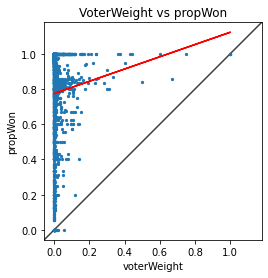

In [203]:
fig, ax = plt.subplots()
plt.plot(x, model.predict(x),color='red')
plt.scatter(x, y, s=5)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.title('VoterWeight vs propWon')
plt.xlabel('voterWeight')
plt.ylabel('propWon')

Looking at the chart above which removes proposals with fewer than five votes and ones where the voter had a weight of less than .0001 there's a clear upward trend (although I don't think a linear fit is appropriate here). The intercept is around 80% this means that most votes are decided by a large margin. I think it's reasonable to weight the vote by the controversy of the vote to better tell who's making more of a decision in the more *controversial* votes. by  dividing the weight by the complement of the winning vote we are bounding the multiplicative effect to be no greater than the number of choices in the vote. 

In [200]:
#saveProgress.csv has the most updated df.
# adjustedWeight = weight/(1-proportionWinning vote. )
df['adjustedWeght'] = df['voterWeight']/(df['propWon'])
df.replace([np.inf, -np.inf], 0,inplace=True)

In [157]:
df.tail()


,Unnamed: 0,spaceIndex,spaceId,spaceSymbol,spaceAddress,proposalId,proposalTitle,proposalBody,proposalChoices,proposalStart,...,voteChoice,voteSpace,processedVotes,voteCounts,totalPropVotes_y,voterWeight,winningVote,wonVote,propWon,adjustedWeght
2067010,2066999.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'1': 27},{'id': 'undeadpastelnft.eth'},"[1, 27]",27,1022347,2.640982e-05,1,True,1.000000,0.000000
2067011,2067000.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'1': 2},{'id': 'undeadpastelnft.eth'},"[1, 2]",2,1022347,1.956283e-06,1,True,0.920455,0.000025
2067012,2067001.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'2': 1},{'id': 'undeadpastelnft.eth'},"[2, 1]",1,1022347,9.781415e-07,1,False,0.897059,0.000010
2067013,2067002.0,5018,skylinedao.eth,ETH,0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b,0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...,Test,More Words,"['A', 'N']",1.642104e+09,...,2,{'id': 'skylinedao.eth'},"[2, 1]",1,2,5.000000e-01,2,True,0.840708,3.138889
2067014,2067003.0,5018,skylinedao.eth,ETH,0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b,0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...,Test,More Words,"['A', 'N']",1.642104e+09,...,1,{'id': 'skylinedao.eth'},"[1, 1]",1,2,5.000000e-01,2,False,0.840708,3.138889


In [ ]:

graphFrame = df[['adjustedWeght', 'propWon']].copy()
counts = graphFrame['adjustedWeght'].value_counts()
graphFrame = graphFrame[~graphFrame['adjustedWeght'].isin(counts[counts < 3].index)]
graphFrame = graphFrame[(graphFrame['adjustedWeght'] >.0001) & (graphFrame['adjustedWeght'] <2)]
#graphFrame = graphFrame[graphFrame['propWon'] <.999]

graphFrame = graphFrame.drop_duplicates()
graphFrame.head()
# scikit x = np.array(graphFrame['adjustedWeght']).reshape((-1, 1))
x = np.array(graphFrame['adjustedWeght'])

y = np.array(graphFrame['propWon'])
fit = np.polyfit(np.exp(x), y, 1)
fitpoly = np.poly1d(fit)

# scikit model = LinearRegression()
# scikit method model.fit((x), y)
fig, ax = plt.subplots()
# scikit model plt.plot(x, model.predict(x),color='red')
plt.scatter(x, y, s =5)
plt.plot(x,fitpoly(x), color='red')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set(xlim=(0, 5), ylim=(0, .1),)
plt.autoscale()
plt.title('adjustedWeight vs propWon')
plt.xlabel('adjustedWeight')
plt.ylabel('propWon')


In [195]:
df.to_csv('saveProgress.csv', index = False)

I want to look at the difference in winning between the two proportions.

In [211]:
lowWeight = df[df['voterWeight'] < .1]
highWeight = df[df['voterWeight'] >= .1]

In [212]:
print(lowWeight['winningVote'].mean())
print(highWeight['winningVote'].mean())

1.570962430507961
1.4277813600515847


In [298]:
updatedDf= df[['proposalId', 'voterWeight', 'wonVote']]
updatedDf =updatedDf.merge(updatedDf.groupby('proposalId').size().rename('propSize'), on = 'proposalId', how='left')
updatedDf = updatedDf[updatedDf['propSize'] > 5]
updatedDf['wonVote'] = updatedDf['wonVote'] * 1
df.tail()

,Unnamed: 0,spaceIndex,spaceId,spaceSymbol,spaceAddress,proposalId,proposalTitle,proposalBody,proposalChoices,proposalStart,...,voteChoice,voteSpace,processedVotes,voteCounts,totalPropVotes_y,voterWeight,winningVote,wonVote,propWon,adjustedWeght
2067010,2066999.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'1': 27},{'id': 'undeadpastelnft.eth'},"[1, 27]",27,1022347,2.640982e-05,1,True,1.000000,0.000026
2067011,2067000.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'1': 2},{'id': 'undeadpastelnft.eth'},"[1, 2]",2,1022347,1.956283e-06,1,True,0.920455,0.000002
2067012,2067001.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'2': 1},{'id': 'undeadpastelnft.eth'},"[2, 1]",1,1022347,9.781415e-07,1,False,0.897059,0.000001
2067013,2067002.0,5018,skylinedao.eth,ETH,0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b,0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...,Test,More Words,"['A', 'N']",1.642104e+09,...,2,{'id': 'skylinedao.eth'},"[2, 1]",1,2,5.000000e-01,2,True,0.840708,0.594737
2067014,2067003.0,5018,skylinedao.eth,ETH,0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b,0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...,Test,More Words,"['A', 'N']",1.642104e+09,...,1,{'id': 'skylinedao.eth'},"[1, 1]",1,2,5.000000e-01,2,False,0.840708,0.594737


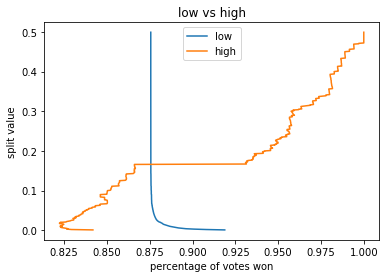

In [314]:
def getSplit(updatedDf, split):  
    #print(updatedDf.head())
    low = updatedDf[updatedDf['voterWeight'] < split]
    low = low['wonVote'].mean()
    high = updatedDf[updatedDf['voterWeight'] >= split]
    high = high['wonVote'].mean()
    return low, high
split = []
low = []
high = []
for i in np.arange(.001, .50, .001):
    x, y = getSplit(updatedDf, i)
    split.append(i)
    low.append(x)
    high.append(y)
ax.set_xlim(.5, 1)
ax.set_ylim(0, .5)
plt.title('low vs high')
plt.xlabel('percentage of votes won')
plt.ylabel('split value')
lowLine =plt.plot(low, split, label="low")
highLine = plt.plot(high, split, label="high")
leg = plt.legend(loc='upper center')



In [256]:
range(.05, 1, .05)

TypeError: 'float' object cannot be interpreted as an integer

I want to analyze the voting records of the whales and see if they vote in pods. 

In [221]:
df.tail()

,Unnamed: 0,spaceIndex,spaceId,spaceSymbol,spaceAddress,proposalId,proposalTitle,proposalBody,proposalChoices,proposalStart,...,voteChoice,voteSpace,processedVotes,voteCounts,totalPropVotes_y,voterWeight,winningVote,wonVote,propWon,adjustedWeght
2067010,2066999.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'1': 27},{'id': 'undeadpastelnft.eth'},"[1, 27]",27,1022347,2.640982e-05,1,True,1.000000,0.000026
2067011,2067000.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'1': 2},{'id': 'undeadpastelnft.eth'},"[1, 2]",2,1022347,1.956283e-06,1,True,0.920455,0.000002
2067012,2067001.0,5016,undeadpastelnft.eth,UPC,0x0811F26C17284B6E331Beaa2328471107576e601,0x235727916b24b2cfa6ef1f23815ad32987cb74b79d57...,In which Metaverse should the Undead Pastel Cl...,NaN,"['Sandbox', 'Decentraland']",1.642124e+09,...,{'2': 1},{'id': 'undeadpastelnft.eth'},"[2, 1]",1,1022347,9.781415e-07,1,False,0.897059,0.000001
2067013,2067002.0,5018,skylinedao.eth,ETH,0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b,0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...,Test,More Words,"['A', 'N']",1.642104e+09,...,2,{'id': 'skylinedao.eth'},"[2, 1]",1,2,5.000000e-01,2,True,0.840708,0.594737
2067014,2067003.0,5018,skylinedao.eth,ETH,0x97f6A6775Bf239EF88b6ca97ACbc2c3d3CfBD10b,0xa591d4b2b14b5c20b40d6957614d9f65e41292da7dc6...,Test,More Words,"['A', 'N']",1.642104e+09,...,1,{'id': 'skylinedao.eth'},"[1, 1]",1,2,5.000000e-01,2,False,0.840708,0.594737
